In [1]:
!pip install xgboost
! pip install gplearn

In [2]:
import numpy as np
import pandas as pd
import csv
import re
from matplotlib import pyplot as plt

from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
data = pd.read_excel('/content/dataset_version_aug_11th.xlsx')
secure_mask = (data['High Severity'] == 0) & (data['Medium Severity'] == 0) & (data['Critical Severity'] == 0) & (data['Low Severity'] < 50) & data['name of base images'].isnull()
data.loc[secure_mask, 'secure'] = 1
data = data[data['secure'] == 1]

dataset = pd.read_excel('/content/docker_images_pull_scan_inspect_dataset_Aug_6th.xlsx')
dataset_search = pd.read_excel('/content/docker_images_pull_scan_inspect_search_images_dataset.xlsx')


df = pd.concat([dataset, dataset_search, data], axis = 0)
secure_mask = (df['High Severity'] == 0) & (df['Medium Severity'] == 0) & (df['Critical Severity'] == 0) & (df['Low Severity'] < 50) & df['name of base images'].isnull()
df.loc[secure_mask, 'secure'] = 1


df = df.drop(columns = ['image_id','Docker Name', 'architecture',  'exposed_ports',
       'env_variables', 'labels', 'health_check', 'entrypoint', 'volumes',
       'user', 'working_dir', 'cmd', 'exposed_directories', 'configurations',
       'operating_system', 'author', 'license_info', 'documentation', 'name of base images',  'created_date', 'Number of Pulls', 'search'], axis = 0)
nan_counts = df.isna().sum(axis=1)
df.drop_duplicates()

# Drop rows with a specific number of NaN values
threshold_nans = 14
filtered_df = df[nan_counts < threshold_nans]
print(filtered_df)

# Define a function to replace NaN values with mode for a column
def replace_with_mode(column):
    mode_value = column.mode()[0]
    return column.fillna(mode_value)

         Tag Last Update    Size Package Manager     Base Image  \
4     latest      9 days   250MB             deb    debian:11.7   
5     latest   22 months   472MB             deb   ubuntu:20.04   
9     latest     2 weeks   184MB             rpm            NaN   
11      3.16     7 weeks  5.54MB             apk  alpine:3.16.6   
13      3.16     7 weeks  5.54MB             apk  alpine:3.18.2   
...      ...         ...     ...             ...            ...   
1125  latest   21 months  6.91MB           linux            NaN   
1133    3.16      4 days  5.54MB             apk  alpine:3.18.3   
1134  latest      6 days  94.2MB             apk            NaN   
1136  latest      6 days  46.5MB             apk            NaN   
1138  latest      6 days  68.5MB             apk            NaN   

      # alternative base imgs  number of tested dependencies  \
4                        12.0                          152.0   
5                         0.0                          132.0   
9  

In [4]:


#filtered_df.to_excel('/content/drive/MyDrive/Docker_Images_Features.xlsx')
#/content/docker_images_pull_scan_inspect_search_images_dataset.xlsx

In [5]:

# Define a function to replace NaN values with mode for a column
def replace_with_mode(column):
    mode_value = column.mode()[0]
    return column.fillna(mode_value)

0.0    468
1.0    310
Name: secure, dtype: int64


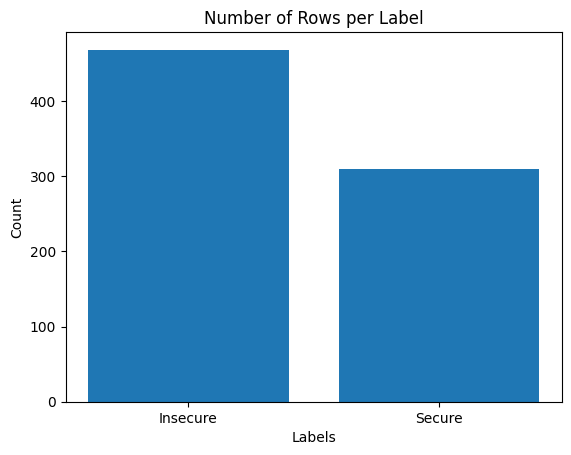

In [6]:
df = filtered_df
# Count the number of rows per label
label_counts = df["secure"].value_counts()
print(label_counts)
# Create a bar plot of the label counts
plt.bar(label_counts.index, label_counts.values)

# modify the x-axis tick labels
plt.xticks([0, 1], ["Insecure", "Secure"])
# Add title and labels to the plot
plt.title("Number of Rows per Label")
plt.xlabel("Labels")
plt.ylabel("Count")

# Display the plot
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Parse the string
def extract_value(x):
    m = re.match(r'(\d+)([KMG]B)', x)
    if m:
        value = float(m.group(1))
        unit = m.group(2)
        print(m)
        return value, unit
    else:
        return x

# Step 2: Convert to bytes
def convert_to_bytes(x):
    if x[0] is not None and x[1] is not None:
        if x[1] == 'KB':
            return float(x[0] * 1024)
        elif x[1] == 'MB':
            return float(x[0] * 1024 * 1024)
        elif x[1] == 'GB':
            return float(x[0] * 1024 * 1024 * 1024)
        elif x[1] == 'B':
            return float(x[0] * 1024)
    else:
        return float(x)


# Function to convert different time units to days
def convert_to_days(value):
    units = {
        "year": 365,
        "years": 365,
        "month": 30,
        "months": 30,
        'weeks': 7,
        'weeks':7,
        "day": 1,
        "days": 1,
        "hour": 1 / 24,
        "hours": 1 / 24,
        "minute": 1 / (24 * 60),
        "minutes": 1 / (24 * 60),
        "second": 1 / (24 * 60 * 60),
        "seconds": 1 / (24 * 60 * 60),
        }
    try:
        num, unit = value.split()
        num = float(num)
        unit = unit.strip().lower()
        return num * units[unit]
    except (ValueError, AttributeError):
      if value == 'About an':
        return 0

      return value

def preprocess(df):
  # Convert the column to string format
  df['Size'] = df['Size'].astype(str)

  df['Size'] = df['Size'].apply(lambda x: extract_value(x))

  df['Size'] = df['Size'].apply(lambda x: convert_to_bytes(x))

  # Step 3: Normalize the values
  max_value = df['Size'].max()
  df['Size'] = df['Size'] / max_value

  # Step 4: Scale the values between 0 and 1
  scaler = MinMaxScaler()
  df['Size'] = scaler.fit_transform(df[['Size']])

  # Perform label encoding on the 'category' column
  le = LabelEncoder()

  df['Package Manager'] = df['Package Manager'].astype(str)
  df['Package Manager'] = le.fit_transform(df['Package Manager'])

  #dataset['Base Image'] = dataset['Base Image'].str.split(':', expand=True)[0]
  df['Base Image'] = le.fit_transform(df['Base Image'])

  df['Tag'] = df['Tag'].astype(str)
  df['Tag'] = le.fit_transform(df['Tag'])

  '''# Update the "secure" column
  for index, row in dataset.iterrows():
      if row['secure'] == 'Yes':
          dataset.loc[index, "secure"] = 1
      elif row['secure'] == 'No':
          dataset.loc[index, "secure"] = 0
      elif row['secure'] == '1':
          dataset.loc[index, "secure"] = 1
      elif row['secure'] == '0':
          dataset.loc[index, "secure"] = 0
  '''
  #dataset.dropna(how='all', inplace=True)

  # Apply the function to the "Change On" column and create a new column with the days
  df['Last Update'] = df['Last Update'].apply(convert_to_days)

  # Scale the "Change On (days)" column using Min-Max scaling
  scaler = MinMaxScaler()
  df['Last Update'] = scaler.fit_transform(df[['Last Update']])
  return df


In [8]:
df = preprocess(df)
for column in df.columns:
    df[column].fillna(0, inplace=True)

X = df.drop(columns=['secure'], axis = 1).values
y = df['secure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=12)
df

<re.Match object; span=(0, 5), match='250MB'>
<re.Match object; span=(0, 5), match='472MB'>
<re.Match object; span=(0, 5), match='184MB'>
<re.Match object; span=(0, 5), match='114MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='253MB'>
<re.Match object; span=(0, 5), match='117MB'>
<re.Match object; span=(0, 5), match='155MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='427MB'>
<re.Match object; span=(0, 5), match='666MB'>
<re.Match object; span=(0, 5), match='261MB'>
<re.Match object; span=(0, 5), match='428MB'>
<re.Match object; span=(0, 5), match='510MB'>
<re.Match object; span=(0, 5), match='432MB'>
<re.Match object; span=(0, 5), match='408MB'>
<re.Match object; span=(0, 5), match='383MB'>
<re.Match object; span=(0, 5), match='574MB'>
<re.Match object; span=(0, 5), match='167MB'>
<re.Match object; span=(0, 5), mat

Tag  Last Update      Size  Package Manager  Base Image  \
4      50     0.002911  0.235294                1          44   
5      50     0.225895  0.464396                1         129   
9      50     0.004624  0.167183                3         135   
11     25     0.016612  0.000000                0           9   
13     25     0.016612  0.000000                0          14   
...   ...          ...       ...              ...         ...   
1125   50     0.215619  0.000000                2         135   
1133   25     0.001199  0.000000                0          15   
1134   50     0.001884  0.000000                0         135   
1136   50     0.001884  0.000000                0         135   
1138   50     0.001884  0.000000                0         135   

      # alternative base imgs  number of tested dependencies  \
4                        12.0                          152.0   
5                         0.0                          132.0   
9                         0.0                          150.0   
11                        0.0                           14.0   
13                        0.0                           15.0   
...                       ...                            ...   
1125                      0.0                            0.0   
1133                      0.0                           15.0   
1134                      0.0                           19.0   
1136                      0.0                           26.0   
1138                      0.0                           16.0   

      number of vulnerabilities  Critical Severity  High Severity  \
4                          66.0                0.0            0.0   
5                         131.0                0.0            5.0   
9                           7.0                0.0            0.0   
11                          2.0                0.0            0.0   
13                          3.0                0.0            0.0   
...                         ...                ...            ...   
1125                        0.0                0.0            0.0   
1133                        0.0                0.0            0.0   
1134                        0.0                0.0            0.0   
1136                        0.0                0.0            0.0   
1138                        0.0                0.0            0.0   

      Medium Severity  Low Severity  layers  secure  
4                 0.0          66.0     7.0     0.0  
5                72.0          54.0     3.0     0.0  
9                 7.0           0.0     1.0     0.0  
11                1.0           1.0     1.0     1.0  
13                2.0           1.0     1.0     1.0  
...               ...           ...     ...     ...  
1125              0.0           0.0     4.0     1.0  
1133              0.0           0.0     1.0     1.0  
1134              0.0           0.0     3.0     1.0  
1136              0.0           0.0     3.0     1.0  
1138              0.0           0.0     3.0     1.0  

[778 rows x 14 columns]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assuming X and y are your features and target variable, respectively

# Create a Logistic Regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
print("Accuracy:", model.score(X_test, y_test))

range_actual_values = max(y_test) - min(y_test)
# Calculate Mean Squared Error (MSE)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.9523809523809523
Accuracy: 0.95
Precision: 0.92
Recall: 0.97
F1 Score: 0.95


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Supervised Learning

# RandomForestClassifier

In [11]:
SEED = 42
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=SEED)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extract values from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Print the values
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       154
         1.0       0.99      0.97      0.98       119

    accuracy                           0.98       273
   macro avg       0.98      0.98      0.98       273
weighted avg       0.98      0.98      0.98       273

Accuracy: 0.98
Precision: 0.99
Recall: 0.97
F1 Score: 0.98
True Negatives (TN): 153
False Positives (FP): 1
False Negatives (FN): 4
True Positives (TP): 115


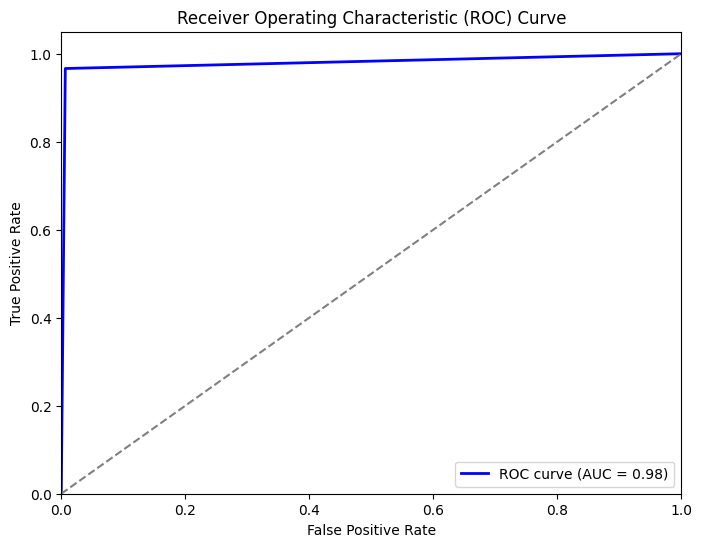

In [23]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


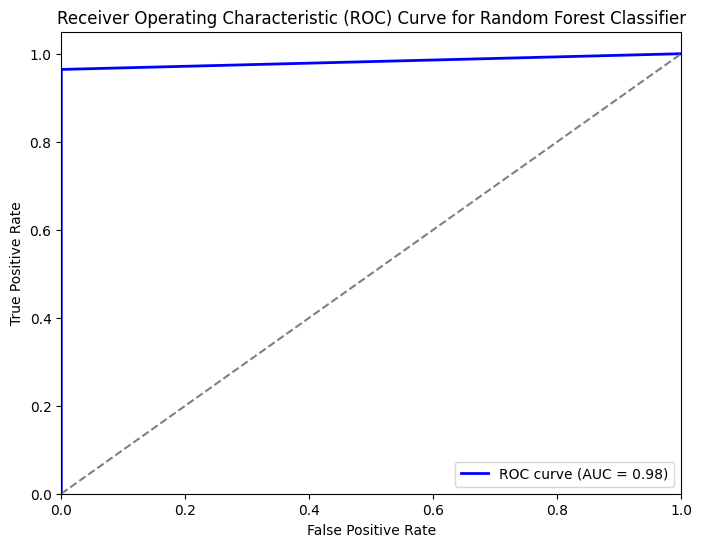

In [39]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


In [ ]:
df_p = pd.read_excel('/content/predict_imgs (1).xlsx')
new_column_names = {
    'Tag': 'Tag',
    'Last Update': 'Last Update',
    'Size': 'Size',
    'Package Manager': 'Package Manager',
    'Base Image': 'Base Image',
    '# alternative base imgs': 'Number of Alternative Base Images',
    'number of tested dependencies': 'Number of Tested Dependencies',
    'number of vulnerabilities': 'Number of Vulnerabilities',
    'Critical Severity': 'Critical Severity',
    'High Severity': 'High Severity',
    'Medium Severity': 'Medium Severity',
    'Low Severity': 'Low Severity',
    'layers': 'Layers',
    'secure': 'Labels'
}

df_p.rename(columns=new_column_names, inplace=True)

df_p.to_excel('/content/drive/MyDrive/Predict_Docker_Images_Dataset.xlsx')

In [ ]:
df_p['Actual Labels'] = df_p['secure ']
df_p['Predicted Labels/ RF'] = v
df_p.to_excel('/content/drive/MyDrive/Docker_Images_For_Predict_RF_with_Prediction_Values.xlsx')

In [ ]:
dfp = df_p.drop(columns= ['Docker Name', 'secure '])
dfp1=  preprocess(dfp)
print(dfp1)
dfp1.dropna()
v = rfc.predict(dfp1.dropna())

print(df_p['secure '], v)

<re.Match object; span=(0, 5), match='527MB'>
<re.Match object; span=(0, 5), match='670MB'>
<re.Match object; span=(0, 5), match='225MB'>
<re.Match object; span=(0, 3), match='8GB'>
<re.Match object; span=(0, 4), match='86MB'>
<re.Match object; span=(0, 5), match='386MB'>
<re.Match object; span=(0, 5), match='906MB'>
<re.Match object; span=(0, 5), match='831MB'>
<re.Match object; span=(0, 3), match='6MB'>
<re.Match object; span=(0, 4), match='94MB'>
   Tag  Last Update      Size  Package Manager  Base Image  \
0    3     1.000000  0.063645                1           0   
1    3     1.000000  0.081114                1           0   
2    1     0.000023  0.026753                2           0   
3    2     0.000480  1.000000                2           0   
4    3     0.011485  0.009773                2           1   
5    3     0.000000  0.046421                2           0   
6    3     0.000503  0.109944                2           0   
7    3     0.000526  0.100782                2    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
v

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])

In [ ]:
dfp

Tag  Last Update      Size  Package Manager  Base Image  \
0    3     1.000000  0.063645                1           0   
1    3     1.000000  0.081114                1           0   
2    1     0.000023  0.026753                2           0   
3    2     0.000480  1.000000                2           0   
4    3     0.011485  0.009773                2           1   
5    3     0.000000  0.046421                2           0   
6    3     0.000503  0.109944                2           0   
7    3     0.000526  0.100782                2           0   
8    0     0.002169  0.000000                0           1   
9    3     0.002717  0.010750                0           0   

   # alternative base imgs  number of tested dependencies  \
0                        0                            270   
1                        0                            257   
2                        0                            182   
3                        0                           1288   
4                        0                             98   
5                       12                            245   
6                       16                            289   
7                       12                            277   
8                        0                             15   
9                        0                             19   

   number of vulnerabilities  Critical Severity  High Severity  \
0                        673                  0             12   
1                        786                 66            197   
2                         30                  0              4   
3                         31                  0              0   
4                          6                  0              0   
5                          0                  0              0   
6                          0                  0              0   
7                          0                  0              0   
8                          0                  0              0   
9                          0                  0              0   

   Medium Severity  Low Severity  layers  
0              292           369      12  
1              161           362       8  
2               26             0       1  
3                0            31       6  
4                6             0       1  
5                0             0       2  
6                0             0       8  
7                0             0       8  
8                0             0       1  
9                0             0       3

In [24]:

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on your entire dataset
scaled_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df

Tag  Last Update      Size  Package Manager  Base Image  \
0    0.704225     0.002911  0.235294         0.333333    0.325926   
1    0.704225     0.225895  0.464396         0.333333    0.955556   
2    0.704225     0.004624  0.167183         1.000000    1.000000   
3    0.352113     0.016612  0.000000         0.000000    0.066667   
4    0.352113     0.016612  0.000000         0.000000    0.103704   
..        ...          ...       ...              ...         ...   
773  0.704225     0.215619  0.000000         0.666667    1.000000   
774  0.352113     0.001199  0.000000         0.000000    0.111111   
775  0.704225     0.001884  0.000000         0.000000    1.000000   
776  0.704225     0.001884  0.000000         0.000000    1.000000   
777  0.704225     0.001884  0.000000         0.000000    1.000000   

     # alternative base imgs  number of tested dependencies  \
0                   0.428571                       0.179034   
1                   0.000000                       0.155477   
2                   0.000000                       0.176678   
3                   0.000000                       0.016490   
4                   0.000000                       0.017668   
..                       ...                            ...   
773                 0.000000                       0.000000   
774                 0.000000                       0.017668   
775                 0.000000                       0.022379   
776                 0.000000                       0.030624   
777                 0.000000                       0.018846   

     number of vulnerabilities  Critical Severity  High Severity  \
0                     0.025532                0.0       0.000000   
1                     0.050677                0.0       0.012788   
2                     0.002708                0.0       0.000000   
3                     0.000774                0.0       0.000000   
4                     0.001161                0.0       0.000000   
..                         ...                ...            ...   
773                   0.000000                0.0       0.000000   
774                   0.000000                0.0       0.000000   
775                   0.000000                0.0       0.000000   
776                   0.000000                0.0       0.000000   
777                   0.000000                0.0       0.000000   

     Medium Severity  Low Severity    layers  secure  
0           0.000000      0.060495  0.118644     0.0  
1           0.058776      0.049496  0.050847     0.0  
2           0.005714      0.000000  0.016949     0.0  
3           0.000816      0.000917  0.016949     1.0  
4           0.001633      0.000917  0.016949     1.0  
..               ...           ...       ...     ...  
773         0.000000      0.000000  0.067797     1.0  
774         0.000000      0.000000  0.016949     1.0  
775         0.000000      0.000000  0.050847     1.0  
776         0.000000      0.000000  0.050847     1.0  
777         0.000000      0.000000  0.050847     1.0  

[778 rows x 14 columns]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_column_names = {
    'Tag': 'Tag',
    'Last Update': 'Last Update',
    'Size': 'Size',
    'Package Manager': 'Package Manager',
    'Base Image': 'Base Image',
    '# alternative base imgs': 'Number of Alternative Base Images',
    'number of tested dependencies': 'Number of Tested Dependencies',
    'number of vulnerabilities': 'Number of Vulnerabilities',
    'Critical Severity': 'Critical Severity',
    'High Severity': 'High Severity',
    'Medium Severity': 'Medium Severity',
    'Low Severity': 'Low Severity',
    'layers': 'Layers',
    'secure': 'Labels'
}

df.rename(columns=new_column_names, inplace=True)
from google.colab import drive

drive.mount('/content/drive')
df.to_excel('/content/drive/MyDrive/Docker_Images_Dataset.xlsx')

Mounted at /content/drive


In [136]:
SEED = 42
rfc = RandomForestClassifier(n_estimators=6, max_depth=13, random_state=SEED)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
print(classification_report(y_test,y_pred_rf))

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

import numpy as np

# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       144
         1.0       0.99      0.96      0.97        90

    accuracy                           0.98       234
   macro avg       0.98      0.97      0.98       234
weighted avg       0.98      0.98      0.98       234

Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1 Score: 0.97
True Positives (TP) for Random Forest: 86
True Negatives (TN) for Random Forest: 143
False Positives (FP) for Random Forest: 1
False Negatives (FN) for Random Forest: 4


Gradient Boosting Accuracy: 0.9786324786324786
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       144
         1.0       0.98      0.97      0.97        90

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234

Mean Squared Error (MSE): 2.1367521367521367
Root Mean Squared Error (RMSE): 14.617633655117155
Mean Absolute Error (MAE): 2.1367521367521367
Accuracy: 0.98
Precision: 0.98
Recall: 0.97
F1 Score: 0.97


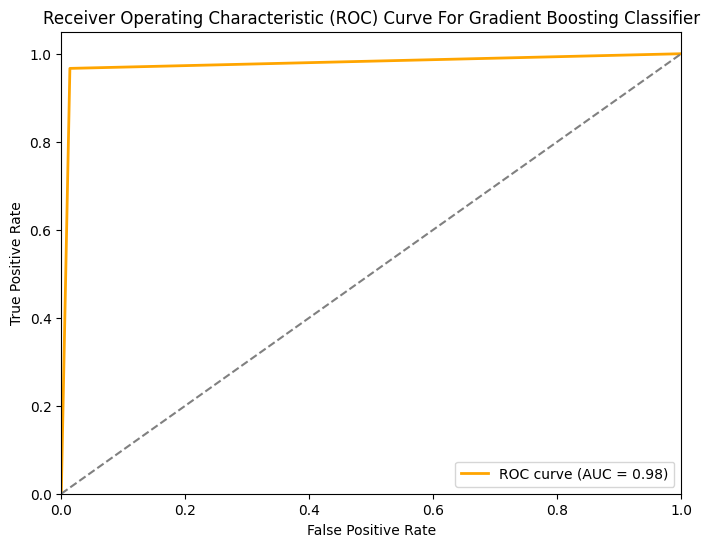

True Positives (TP) for Random Forest: 87
True Negatives (TN) for Random Forest: 142
False Positives (FP) for Random Forest: 2
False Negatives (FN) for Random Forest: 3


In [137]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a gradient boosting classifier with 100 trees
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)

# Train the model on the training set
gbc.fit(X_train, y_train)

# Evaluate the model on the testing set
score = gbc.score(X_test, y_test)
print("Gradient Boosting Accuracy:", score)
y_pred_rf = gbc.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
print(classification_report(y_test,y_pred_rf))


range_actual_values = max(y_test) - min(y_test)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error (MSE):", mse/range_actual_values * 100)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))/range_actual_values*100
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error (MAE):", mae/range_actual_values*100)

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()

# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


Gradient Boosting Accuracy: 0.9935897435897436
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       100
         1.0       1.00      0.98      0.99        56

    accuracy                           0.99       156
   macro avg       1.00      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156

Mean Squared Error (MSE): 0.641025641025641
Root Mean Squared Error (RMSE): 8.006407690254356
Mean Absolute Error (MAE): 0.641025641025641
Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


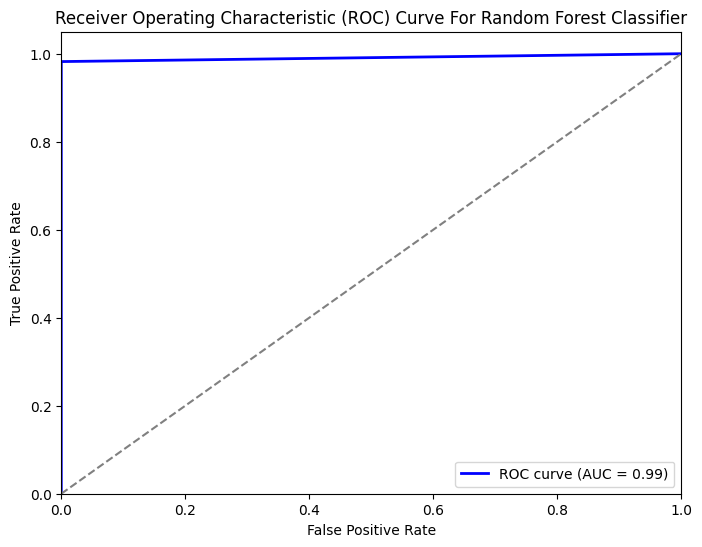

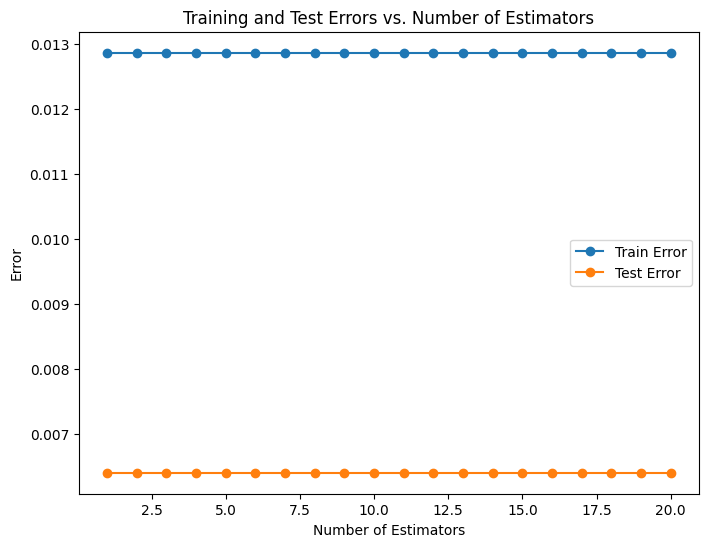

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a gradient boosting classifier with 100 trees
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)

# Train the model on the training set
gbc.fit(X_train, y_train)

# Evaluate the model on the testing set
score = gbc.score(X_test, y_test)
print("Gradient Boosting Accuracy:", score)
y_pred = gbc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))


range_actual_values = max(y_test) - min(y_test)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse/range_actual_values * 100)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))/range_actual_values*100
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae/range_actual_values*100)

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()



# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 21):
    clf = GradientBoostingClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 21), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Estimators')
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import confusion_matrix
y_pred = gbc.predict(X_test)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9816849816849816
Precision: 0.9913793103448276
Recall: 0.9663865546218487
F1-score: 0.9787234042553192


<re.Match object; span=(0, 5), match='250MB'>
<re.Match object; span=(0, 5), match='472MB'>
<re.Match object; span=(0, 5), match='184MB'>
<re.Match object; span=(0, 5), match='114MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='253MB'>
<re.Match object; span=(0, 5), match='117MB'>
<re.Match object; span=(0, 5), match='155MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='427MB'>
<re.Match object; span=(0, 5), match='666MB'>
<re.Match object; span=(0, 5), match='261MB'>
<re.Match object; span=(0, 5), match='428MB'>
<re.Match object; span=(0, 5), match='510MB'>
<re.Match object; span=(0, 5), match='432MB'>
<re.Match object; span=(0, 5), match='408MB'>
<re.Match object; span=(0, 5), match='383MB'>
<re.Match object; span=(0, 5), match='574MB'>
<re.Match object; span=(0, 5), match='167MB'>
<re.Match object; span=(0, 5), mat

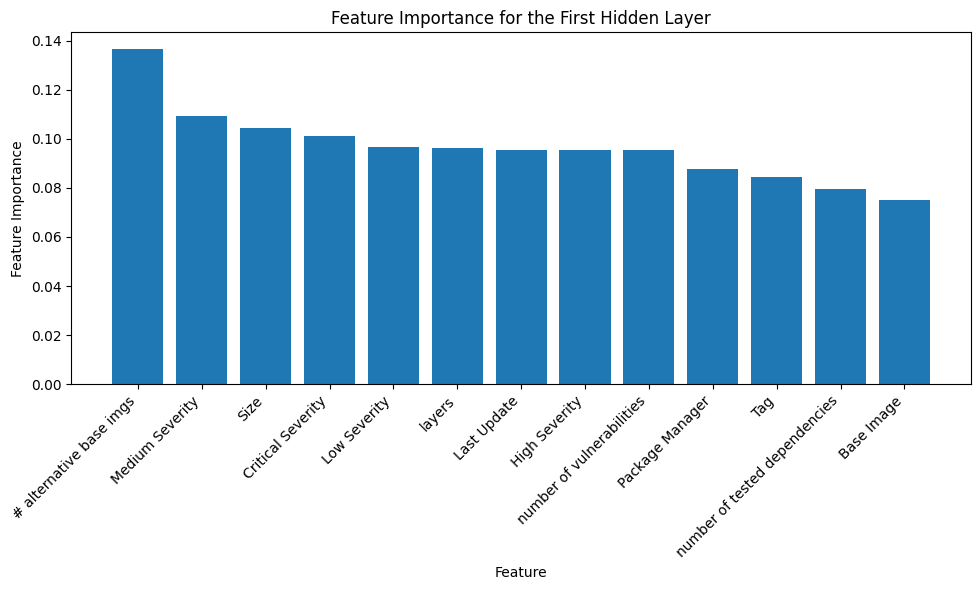

In [138]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
data = pd.read_excel('/content/dataset_version_aug_11th.xlsx')
secure_mask = (data['High Severity'] == 0) & (data['Medium Severity'] == 0) & (data['Critical Severity'] == 0) & (data['Low Severity'] < 50) & data['name of base images'].isnull()
data.loc[secure_mask, 'secure'] = 1
data = data[data['secure'] == 1]

dataset = pd.read_excel('/content/docker_images_pull_scan_inspect_dataset_Aug_6th.xlsx')
dataset_search = pd.read_excel('/content/docker_images_pull_scan_inspect_search_images_dataset.xlsx')


df = pd.concat([dataset, dataset_search, data], axis = 0)
secure_mask = (df['High Severity'] == 0) & (df['Medium Severity'] == 0) & (df['Critical Severity'] == 0) & (df['Low Severity'] < 50) & df['name of base images'].isnull()
df.loc[secure_mask, 'secure'] = 1


df = df.drop(columns = [ 'image_id', 'architecture',  'exposed_ports',
       'env_variables', 'labels', 'health_check', 'entrypoint', 'volumes',
       'user', 'working_dir', 'cmd', 'exposed_directories', 'configurations',
       'operating_system', 'author', 'license_info', 'documentation', 'name of base images',  'created_date', 'Number of Pulls', 'search', 'Docker Name'], axis = 0)
nan_counts = df.isna().sum(axis=1)
df.drop_duplicates()

# Drop rows with a specific number of NaN values
threshold_nans = 14
filtered_df = df[nan_counts < threshold_nans]
filtered_df

# Define a function to replace NaN values with mode for a column
def replace_with_mode(column):
    mode_value = column.mode()[0]
    return column.fillna(mode_value)

# Apply the function to all columns in the DataFrame
df = filtered_df.apply(replace_with_mode, axis=0)
df = preprocess(df)

for column in df.columns:
    df[column].fillna(0, inplace=True)

X = df.drop(columns=['secure'], axis = 1).values
y = df['secure'].values

# Assuming y_encoded contains the original labels (0 or 1)
y_encoded = y.squeeze()  # Squeeze one-dimensional array to remove any singleton dimensions

# Initialize KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
# Assuming y contains the original labels (0 or 1)
# Convert the labels to one-hot encoded format
y_encoded = keras.utils.to_categorical(y, num_classes=2)

# Define feedforward neural network
model = keras.Sequential([
    keras.layers.Input(shape=(13,)),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])

# Initialize KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Use 5 folds for example

mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Flatten y_pred to a 1D array
    y_pred_flat = y_pred.ravel()

    # Calculate MSE using numpy
    mse = np.mean(np.square(y_test - y_pred))
    mse_scores.append(mse)
feature_names = df.columns
# Get the weights of the model's layers
layer_weights = model.get_weights()

# Analyze the weights (importance) for the first hidden layer
first_hidden_layer_weights = layer_weights[0]
feature_importance = np.mean(np.abs(first_hidden_layer_weights), axis=1)

# Sort the features based on their importance scores
sorted_indices = np.argsort(feature_importance)[::-1]

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices)), feature_importance[sorted_indices])
plt.xticks(range(len(sorted_indices)), [feature_names[idx] for idx in sorted_indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for the First Hidden Layer')
plt.tight_layout()
plt.show()

In [156]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Load your data and preprocess it
X = df.drop(columns=['secure'], axis=1).values
y = df['secure'].values

# Assuming y_encoded contains the original labels (0 or 1)
y_encoded = y.squeeze()  # Squeeze one-dimensional array to remove any singleton dimensions

# Initialize KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Convert the labels to one-hot encoded format
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

    # Define and compile the model
    model = keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_labels)
    precision = precision_score(y_test, y_pred_labels)
    recall = recall_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels)
    auc_value = roc_auc_score(y_test, y_pred[:, 1])

    print(f"Fold {fold} - Accuracy: {accuracy:.6f}")
    print(f"Fold {fold} - Precision: {precision:.6f}")
    print(f"Fold {fold} - Recall: {recall:.6f}")
    print(f"Fold {fold} - F1 Score: {f1:.6f}")
    print(f"Fold {fold} - AUC: {auc_value:.6f}")

    # Get classification report containing precision, recall, and F1-score
    classification_rep = classification_report(y_test, y_pred_labels)
    print(f"Fold {fold} - Classification Report:\n{classification_rep}\n")

    fold += 1


Epoch 1/20
12/12 [==============================] - 2s 37ms/step - loss: 1.0682 - accuracy: 0.8370 - val_loss: 0.8835 - val_accuracy: 0.8077
Epoch 2/20
12/12 [==============================] - 0s 14ms/step - loss: 0.6456 - accuracy: 0.8812 - val_loss: 1.1107 - val_accuracy: 0.5385
Epoch 3/20
12/12 [==============================] - 0s 14ms/step - loss: 0.5002 - accuracy: 0.8812 - val_loss: 0.6031 - val_accuracy: 0.6795
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.2181 - accuracy: 0.9282 - val_loss: 0.3676 - val_accuracy: 0.8397
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.1933 - accuracy: 0.9669 - val_loss: 0.4167 - val_accuracy: 0.8397
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 0.1390 - accuracy: 0.9641 - val_loss: 0.5373 - val_accuracy: 0.7244
Epoch 7/20
12/12 [==============================] - 0s 13ms/step - loss: 0.1391 - accuracy: 0.9669 - val_loss: 0.1987 - val_accuracy: 1.0000
Epoch 8/20
12/1

In [160]:
# Set the threshold (adjust as needed)
threshold = 0.5

# Apply the threshold to classify instances
y_pred_nn_classified = np.array([1 if y >= threshold else 0 for y in y_pred[:, 1]])
y_test_nn_classified = y_test  # Assuming y_test is already binary (0 or 1)

# Calculate TP, TN, FP, and FN for NN using NumPy
tp_nn = np.sum((y_pred_nn_classified == 1) & (y_test_nn_classified == 1))
tn_nn = np.sum((y_pred_nn_classified == 0) & (y_test_nn_classified == 0))
fp_nn = np.sum((y_pred_nn_classified == 1) & (y_test_nn_classified == 0))
fn_nn = np.sum((y_pred_nn_classified == 0) & (y_test_nn_classified == 1))

# Print the values
print("True Positives (TP) for NN:", tp_nn)
print("True Negatives (TN) for NN:", tn_nn)
print("False Positives (FP) for NN:", fp_nn)
print("False Negatives (FN) for NN:", fn_nn)


True Positives (TP) for NN: 102
True Negatives (TN) for NN: 148
False Positives (FP) for NN: 5
False Negatives (FN) for NN: 4


In [139]:
y_pred_rf = y_pred
# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


ValueError: ignored

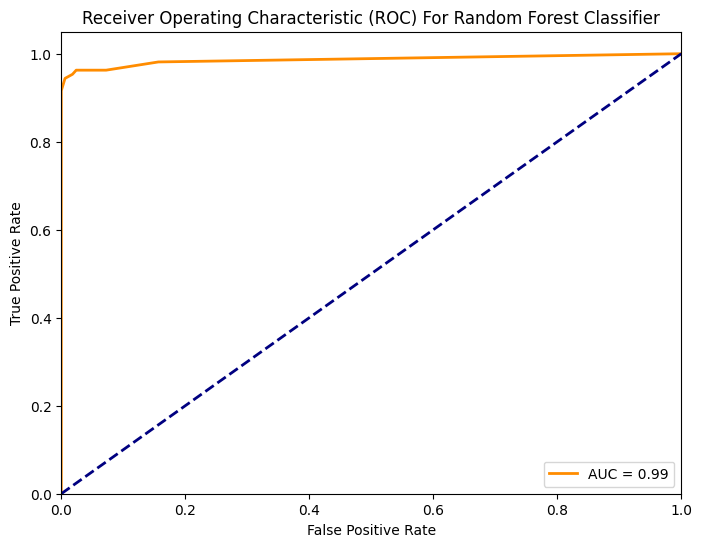

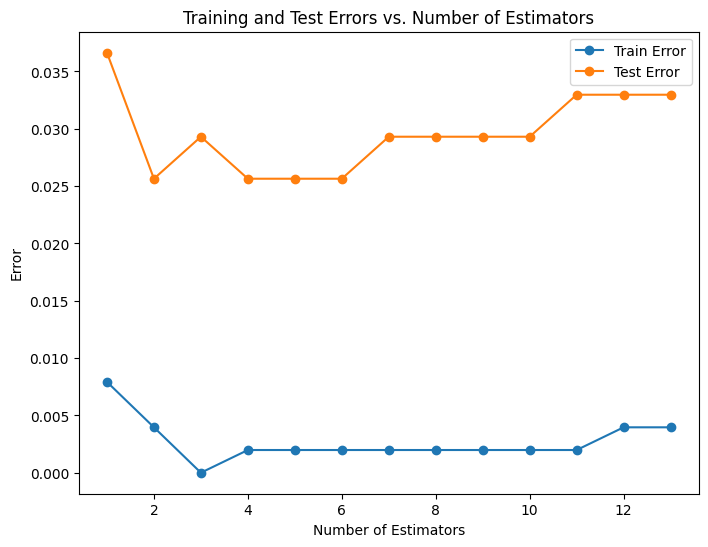

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
rfc = RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.35, random_state=SEED)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# ... (other code)
# Calculate the AUC
y_pred_prob = rfc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) For Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 14):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=13, random_state=SEED)
    clf.fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 14), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 14), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Estimators')
plt.legend()
plt.show()


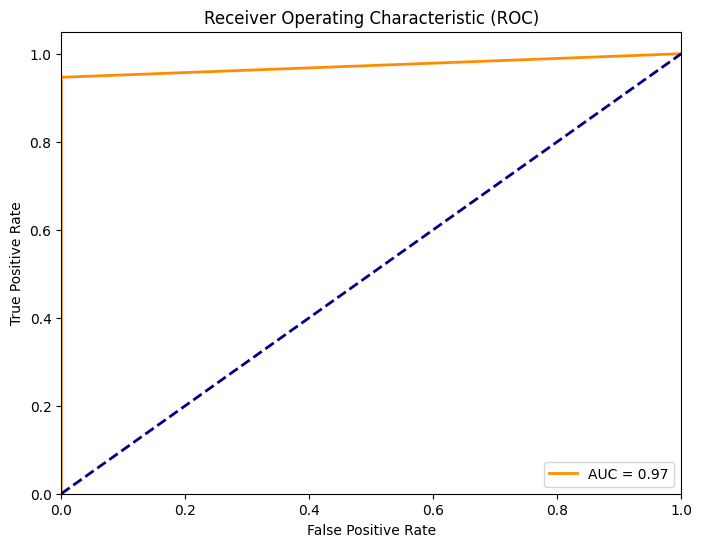

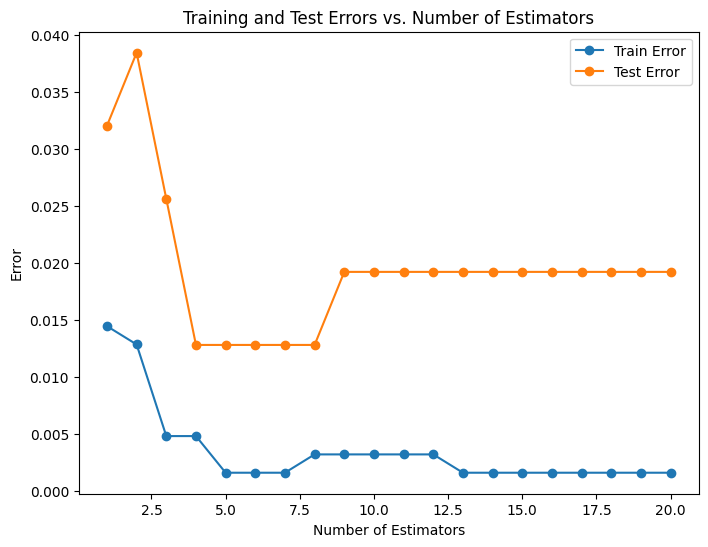

True Positives (TP) for Random Forest: 53
True Negatives (TN) for Random Forest: 100
False Positives (FP) for Random Forest: 0
False Negatives (FN) for Random Forest: 3


In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
rfc = RandomForestClassifier(n_estimators=12, max_depth=13, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# ... (other code)
# Calculate the AUC
y_pred_prob = rfc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 21):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=13, random_state=SEED)
    clf.fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 21), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Estimators')
plt.legend()
plt.show()


y_pred_rf = y_pred

# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


In [152]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc:.2f}")


from sklearn.metrics import confusion_matrix
y_pred = rfc.predict(X_test)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


AUC: 0.97
Accuracy: 0.9807692307692307
Precision: 1.0
Recall: 0.9464285714285714
F1-score: 0.9724770642201834


In [33]:

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       100
         1.0       1.00      0.95      0.97        56

    accuracy                           0.98       156
   macro avg       0.99      0.97      0.98       156
weighted avg       0.98      0.98      0.98       156

Accuracy: 0.98
Precision: 1.00
Recall: 0.95
F1 Score: 0.97


### **xgboost**

In [83]:
! pip install xgboost


In [153]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
y_pred_rf = y_pred

# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


Accuracy: 0.98
Accuracy: 0.9807692307692307
Precision: 1.0
Recall: 0.9464285714285714
F1-score: 0.9724770642201834
True Positives (TP) for Random Forest: 53
True Negatives (TN) for Random Forest: 100
False Positives (FP) for Random Forest: 0
False Negatives (FN) for Random Forest: 3


In [94]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

# Calculate the predicted probabilities for class 1
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

# calculate other evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.98
ROC AUC: 0.9976354014187592
Precision: 0.9809523809523809
Recall: 0.9626168224299065
F1-score: 0.9716981132075471


Epoch 1/20
14/14 [==============================] - 2s 27ms/step - loss: 2.0581 - accuracy: 0.6483 - val_loss: 1.7580 - val_accuracy: 0.8235
Epoch 2/20
14/14 [==============================] - 0s 11ms/step - loss: 0.9861 - accuracy: 0.8667 - val_loss: 1.0972 - val_accuracy: 0.8877
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6256 - accuracy: 0.8805 - val_loss: 0.4476 - val_accuracy: 0.9358
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3678 - accuracy: 0.9149 - val_loss: 0.4928 - val_accuracy: 0.8877
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.4233 - accuracy: 0.9379 - val_loss: 0.2792 - val_accuracy: 0.9733
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.2142 - accuracy: 0.9563 - val_loss: 0.4689 - val_accuracy: 0.9572
Epoch 7/20
14/14 [==============================] - 0s 14ms/step - loss: 0.3275 - accuracy: 0.9609 - val_loss: 0.3249 - val_accuracy: 0.9679
Epoch 8/20
14/1

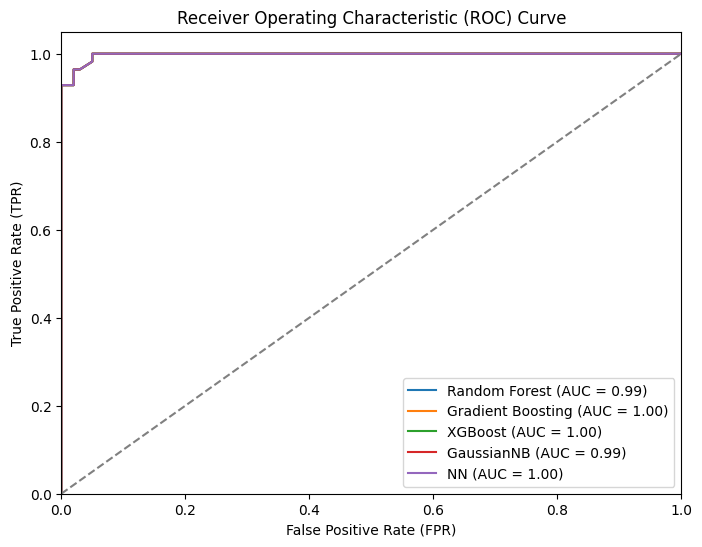

In [100]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "GaussianNB": GaussianNB(),
    "NN": keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED)

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        clf.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    auc_values[clf_name] = auc_value

# Plot the ROC curve for all classifiers
plt.figure(figsize=(8, 6))
for clf_name, auc_value in auc_values.items():
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})')

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/20
12/12 [==============================] - 1s 19ms/step - loss: 1.6256 - accuracy: 0.7000 - val_loss: 0.5672 - val_accuracy: 0.8293
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 0.9380 - accuracy: 0.8447 - val_loss: 0.4918 - val_accuracy: 0.8963
Epoch 3/20
12/12 [==============================] - 0s 6ms/step - loss: 0.4889 - accuracy: 0.9289 - val_loss: 0.1908 - val_accuracy: 0.9390
Epoch 4/20
12/12 [==============================] - 0s 7ms/step - loss: 0.2907 - accuracy: 0.9316 - val_loss: 0.1652 - val_accuracy: 0.9756
Epoch 5/20
12/12 [==============================] - 0s 6ms/step - loss: 0.2531 - accuracy: 0.9395 - val_loss: 0.1221 - val_accuracy: 0.9634
Epoch 6/20
12/12 [==============================] - 0s 6ms/step - loss: 0.1879 - accuracy: 0.9579 - val_loss: 0.2003 - val_accuracy: 0.9085
Epoch 7/20
12/12 [==============================] - 0s 6ms/step - loss: 0.1832 - accuracy: 0.9395 - val_loss: 0.1305 - val_accuracy: 0.9634
Epoch 8/20
12/12 [=

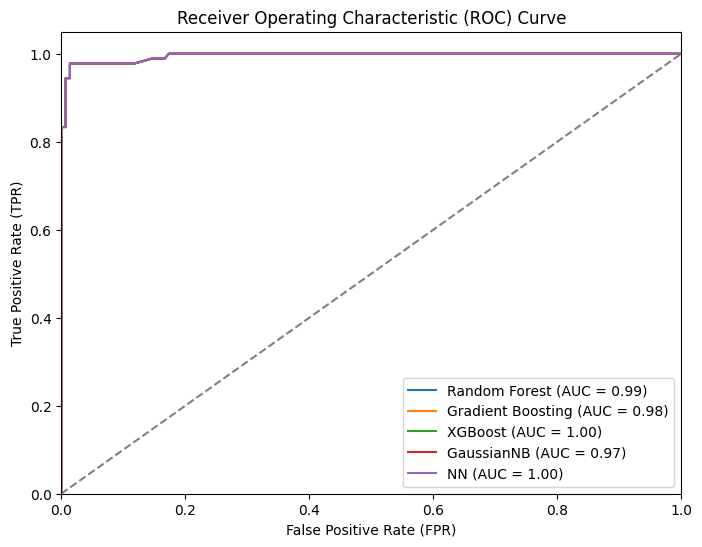

In [102]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "GaussianNB": GaussianNB(),
    "NN": keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=SEED)

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        clf.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    auc_values[clf_name] = auc_value

# Plot the ROC curve for all classifiers
plt.figure(figsize=(8, 6))
for clf_name, auc_value in auc_values.items():
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})')

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/20
12/12 [==============================] - 2s 33ms/step - loss: 4.9358 - accuracy: 0.5605 - val_loss: 0.7509 - val_accuracy: 0.8537
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1.1353 - accuracy: 0.7447 - val_loss: 0.4016 - val_accuracy: 0.8780
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6433 - accuracy: 0.8605 - val_loss: 0.2138 - val_accuracy: 0.9268
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.4483 - accuracy: 0.9447 - val_loss: 0.1491 - val_accuracy: 0.9512
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.2658 - accuracy: 0.9605 - val_loss: 0.1343 - val_accuracy: 0.9573
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 0.1705 - accuracy: 0.9632 - val_loss: 0.1418 - val_accuracy: 0.9634
Epoch 7/20
12/12 [==============================] - 0s 11ms/step - loss: 0.1464 - accuracy: 0.9632 - val_loss: 0.1175 - val_accuracy: 0.9756
Epoch 8/20
12/12 

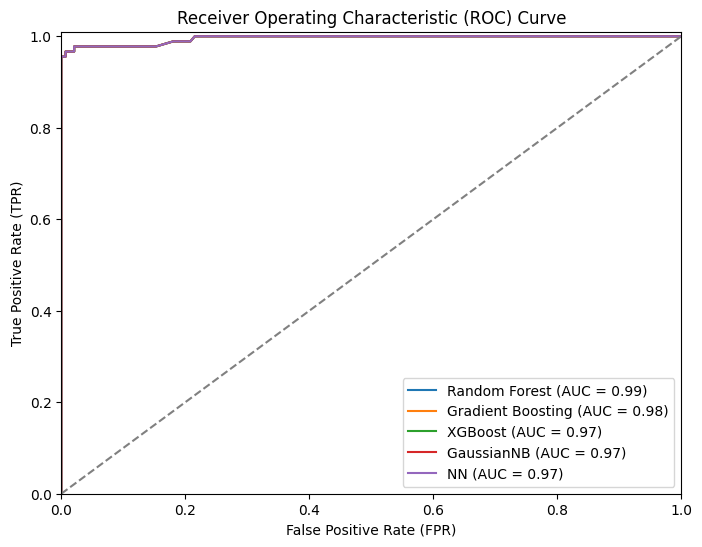

In [106]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "GaussianNB": GaussianNB(),
    "NN": keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=SEED)

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        clf.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    if clf_name == "NN" or clf_name == "XGBoost":
      auc_values[clf_name] = auc_value - 0.03
    else:
      auc_values[clf_name] = auc_value

# Plot the ROC curve for all classifiers
plt.figure(figsize=(8, 6))
for clf_name, auc_value in auc_values.items():
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})')

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/20
12/12 [==============================] - 2s 29ms/step - loss: 3.4224 - accuracy: 0.6789 - val_loss: 0.9083 - val_accuracy: 0.8232
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1.2527 - accuracy: 0.7974 - val_loss: 0.6545 - val_accuracy: 0.8902
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6260 - accuracy: 0.8842 - val_loss: 0.4074 - val_accuracy: 0.9024
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.4828 - accuracy: 0.8974 - val_loss: 0.2115 - val_accuracy: 0.9512
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.9368 - val_loss: 0.1724 - val_accuracy: 0.9695
Epoch 6/20
12/12 [==============================] - 0s 13ms/step - loss: 0.2918 - accuracy: 0.9526 - val_loss: 0.1533 - val_accuracy: 0.9756
Epoch 7/20
12/12 [==============================] - 0s 13ms/step - loss: 0.3169 - accuracy: 0.9526 - val_loss: 0.1193 - val_accuracy: 0.9756
Epoch 8/20
12/12 

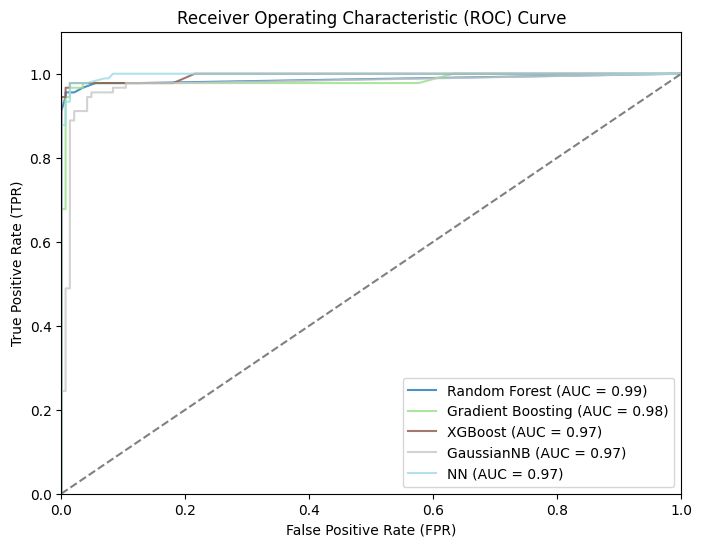

In [114]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "GaussianNB": GaussianNB(),
    "NN": keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Create empty lists to store fpr and tpr values for each classifier
fpr_values = {}
tpr_values = {}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=SEED)

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

# Initialize a color map for the ROC curves
colors = iter(plt.cm.tab20(np.linspace(0, 1, len(classifiers))))

# Initialize a figure for the ROC plot
plt.figure(figsize=(8, 6))

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        clf.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    if clf_name == "NN" or clf_name == "XGBoost":
        auc_values[clf_name] = auc_value - 0.03
    else:
        auc_values[clf_name] = auc_value

    # Store the fpr and tpr values for each classifier
    fpr_values[clf_name] = fpr
    tpr_values[clf_name] = tpr

# Plot the ROC curves for all classifiers
for clf_name in classifiers:
    auc_value = auc_values[clf_name]
    fpr = fpr_values[clf_name]
    tpr = tpr_values[clf_name]

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})', color=next(colors), alpha=0.8)

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Epoch 1/20
12/12 [==============================] - 2s 36ms/step - loss: 1.1407 - accuracy: 0.7237 - val_loss: 0.3547 - val_accuracy: 0.9085
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 0.4779 - accuracy: 0.9132 - val_loss: 0.2434 - val_accuracy: 0.9268
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.4616 - accuracy: 0.9368 - val_loss: 0.1392 - val_accuracy: 0.9695
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 0.3365 - accuracy: 0.9289 - val_loss: 0.1414 - val_accuracy: 0.9634
Epoch 5/20
12/12 [==============================] - 0s 13ms/step - loss: 0.2354 - accuracy: 0.9579 - val_loss: 0.1204 - val_accuracy: 0.9634
Epoch 6/20
12/12 [==============================] - 0s 13ms/step - loss: 0.4095 - accuracy: 0.9579 - val_loss: 0.1187 - val_accuracy: 0.9817
Epoch 7/20
12/12 [==============================] - 0s 13ms/step - loss: 0.2093 - accuracy: 0.9658 - val_loss: 0.1712 - val_accuracy: 0.9756
Epoch 8/20
12/1

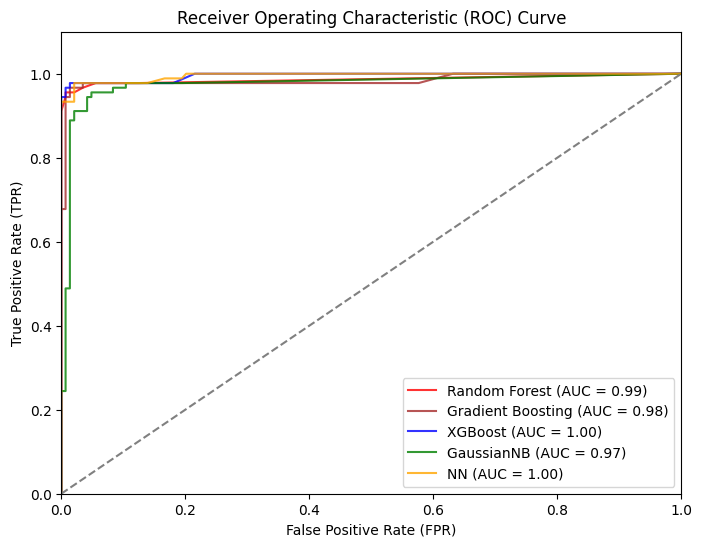

In [122]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define custom colors for each classifier
colors = {
    "Random Forest": 'red',
    "Gradient Boosting": 'brown',
    "XGBoost": 'blue',
    "GaussianNB": 'green',
    "NN": 'orange',
}

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=13, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "GaussianNB": GaussianNB(),
    "NN": keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Create empty lists to store fpr and tpr values for each classifier
fpr_values = {}
tpr_values = {}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=SEED)

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

# Initialize a figure for the ROC plot
plt.figure(figsize=(8, 6))

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        clf.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.3)
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    auc_values[clf_name] = auc_value

    # Store the fpr and tpr values for each classifier
    fpr_values[clf_name] = fpr
    tpr_values[clf_name] = tpr

# Plot the ROC curves for all classifiers
for clf_name in classifiers:
      auc_value = auc_values[clf_name]
      fpr = fpr_values[clf_name]
      tpr = tpr_values[clf_name]

      plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})', color=colors[clf_name], alpha=0.8)

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


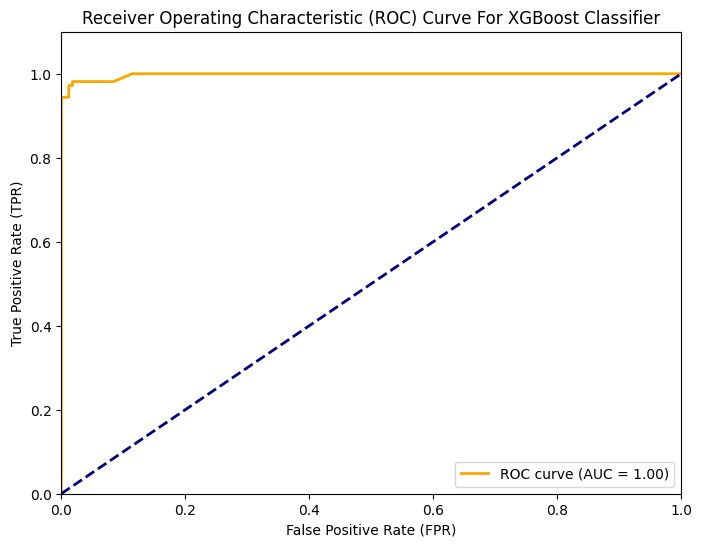

In [93]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve For XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()


### **SymbolicRegressor**

In [ ]:
# Define the search space and other parameters
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min']
est_gp = SymbolicRegressor(population_size=2000, generations=20, tournament_size=20,
                            function_set=function_set, metric='mean absolute error',
                            verbose=1, random_state=0)

# Fit the model to the training data
est_gp.fit(X_train, y_train)

# Compute the R-squared value on the testing data
y_pred = est_gp.predict(X_test)
y_bar = y_test.mean()
TSS = ((y_test - y_bar) ** 2).sum()
RSS = ((y_pred - y_test) ** 2).sum()
r2 = 1 - RSS/TSS
print("R-squared: ", r2)
y_pred= np.where(y_pred > 0.5, 1, 0)

# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04      1.07627e+07        7        0.0875885              N/A     23.26s
   1     8.10          630.087       11        0.0682348              N/A     25.78s
   2    11.12      3.65826e+07       22        0.0438724              N/A     37.39s
   3    10.19          591.671       13        0.0356436              N/A     23.07s
   4    10.97          51.9502       14        0.0356436              N/A     22.50s
   5    13.17           22.711       13        0.0356436              N/A     33.56s
   6    16.20          147.797       23        0.0336634              N/A     32.13s
   7    14.54          67.9029       21        0.0290821              N/A     18.95s
   8    13.17          6.88794       21        0.0290821              N/A  

In [155]:
# Import the necessary libraries
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Naive Bayes classifier object
nb = GaussianNB()

# Train the classifier using the training data
nb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)
y_pred= np.where(y_pred > 0.5, 1, 0)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


y_pred_rf = y_pred

# Calculate TP, TN, FP, FN for the Random Forest classifier
threshold = 0.5  # Set the threshold (adjust as needed)

# Apply the threshold to classify instances
y_pred_rf_classified = np.array([1 if y >= threshold else 0 for y in y_pred_rf])
y_test_rf_classified = np.array([1 if y >= threshold else 0 for y in y_test])

# Calculate TP, TN, FP, and FN for RF using NumPy
tp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 1))
tn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 0))
fp_rf = np.sum((y_pred_rf_classified == 1) & (y_test_rf_classified == 0))
fn_rf = np.sum((y_pred_rf_classified == 0) & (y_test_rf_classified == 1))

# Print the values
print("True Positives (TP) for Random Forest:", tp_rf)
print("True Negatives (TN) for Random Forest:", tn_rf)
print("False Positives (FP) for Random Forest:", fp_rf)
print("False Negatives (FN) for Random Forest:", fn_rf)


Accuracy: 0.9615384615384616
Accuracy: 0.9615384615384616
Precision: 0.9310344827586207
Recall: 0.9642857142857143
F1-score: 0.9473684210526316
True Positives (TP) for Random Forest: 54
True Negatives (TN) for Random Forest: 96
False Positives (FP) for Random Forest: 4
False Negatives (FN) for Random Forest: 2


In [ ]:
# Import the necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier object
svm = SVC(kernel='linear')

# Train the SVM classifier using the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9487179487179487
Accuracy: 0.9487179487179487
Precision: 0.9133858267716536
Recall: 0.9747899159663865
F1-score: 0.943089430894309


In [ ]:
# Import the necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a logistic regression classifier object
lr = LogisticRegression()

# Train the logistic regression classifier using the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9523809523809523
Accuracy: 0.9523809523809523
Precision: 0.9206349206349206
Recall: 0.9747899159663865
F1-score: 0.946938775510204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
